In [1]:
import os

import numpy as np
import random
import tensorflow as tf

# Set seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


# Function to append logs
def append_log(content):
    """Appends a string to the log file inside the model directory."""
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)
    with open(log_file_path, "a", encoding="utf-8") as file:
        file.write(content + "\n")


/home/aymenbj/AERL39_2/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ismModifDoss="DETERMINISTIC_Layer_original"
ismModif="50e"
Modif_desc=""
ismModifDataset="DETERMINISTIC"
ismModifN=""



# Define log file path with _"+ismModif"

model_dir = "models_KDD_" + ismModifDoss
log_file_path = os.path.join(model_dir, "training_log_" + ismModif + ".txt")
append_log(Modif_desc+'\n')
h5_model_path = os.path.join(model_dir, "defender_agent_model_Full_" + ismModif + ".h5")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
import json
from sklearn.utils import shuffle
import os
import sys
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score,recall_score, precision_score
import pandas as pd
from tensorflow.keras.models import model_from_json

# Import definitions from your training file.
# It is assumed that this file defines the following:
#   - ismModifDoss, ismModif, ismModifDataset (used for file naming)
#   - RLenv: the environment class for loading/formatting data
#   - huber_loss: your custom loss function
# (Other classes such as DefenderAgent, etc., are defined but for AERL fine tuning
# we work directly with the defender’s Keras model.)

from gan_model import * 

import tensorflow.keras.backend as K  # ✅ Import K globally
from tensorflow.keras.models import load_model

In [4]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO, WARNING, and DEBUG messages
import tensorflow as tf
#tf.get_logger().setLevel('ERROR')  # Only show errors from TensorFlow's logger




class data_cls:
    def __init__(self,train_test,**kwargs):
        col_names = ["duration","protocol_type","service","flag","src_bytes",
            "dst_bytes","land_f","wrong_fragment","urgent","hot","num_failed_logins",
            "logged_in","num_compromised","root_shell","su_attempted","num_root",
            "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
            "is_host_login","is_guest_login","count","srv_count","serror_rate",
            "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
            "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
            "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
            "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
            "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","dificulty"]
        self.index = 0
        # Data formated path and test path. 
        self.loaded = False
        self.train_test = train_test
        self.train_path = kwargs.get('train_path', '../datasets/KDD/KDDTrain+.txt')
        self.test_path = kwargs.get('test_path', '../datasets/KDD/KDDTest+.txt')
        
        self.formated_train_path = kwargs.get('formated_train_path', 
                                              "formated_train_adv_"+ismModifDataset+".data")
        self.formated_test_path = kwargs.get('formated_test_path',
                                             "formated_test_adv_"+ismModifDataset+".data")
        
        self.attack_types = ['normal','DoS','Probe','R2L','U2R']
        self.attack_names = []
        self.attack_map =   { 'normal': 'normal',
                        
                        'back': 'DoS',
                        'land': 'DoS',
                        'neptune': 'DoS',
                        'pod': 'DoS',
                        'smurf': 'DoS',
                        'teardrop': 'DoS',
                        'mailbomb': 'DoS',
                        'apache2': 'DoS',
                        'processtable': 'DoS',
                        'udpstorm': 'DoS',
                        
                        'ipsweep': 'Probe',
                        'nmap': 'Probe',
                        'portsweep': 'Probe',
                        'satan': 'Probe',
                        'mscan': 'Probe',
                        'saint': 'Probe',
                    
                        'ftp_write': 'R2L',
                        'guess_passwd': 'R2L',
                        'imap': 'R2L',
                        'multihop': 'R2L',
                        'phf': 'R2L',
                        'spy': 'R2L',
                        'warezclient': 'R2L',
                        'warezmaster': 'R2L',
                        'sendmail': 'R2L',
                        'named': 'R2L',
                        'snmpgetattack': 'R2L',
                        'snmpguess': 'R2L',
                        'xlock': 'R2L',
                        'xsnoop': 'R2L',
                        'worm': 'R2L',
                        
                        'buffer_overflow': 'U2R',
                        'loadmodule': 'U2R',
                        'perl': 'U2R',
                        'rootkit': 'U2R',
                        'httptunnel': 'U2R',
                        'ps': 'U2R',    
                        'sqlattack': 'U2R',
                        'xterm': 'U2R'
                    }
        self.all_attack_names = list(self.attack_map.keys())

        formated = False     
        
        # Test formated data exists
        if os.path.exists(self.formated_train_path) and os.path.exists(self.formated_test_path):
            formated = True
       
        self.formated_dir = "../datasets/formated/"
        if not os.path.exists(self.formated_dir):
            os.makedirs(self.formated_dir)
               
            
        # If it does not exist, it's needed to format the data
        if not formated:
            ''' Formating the dataset for ready-2-use data'''
            self.df = pd.read_csv(self.train_path,sep=',',names=col_names,index_col=False)
            if 'dificulty' in self.df.columns:
                self.df.drop('dificulty', axis=1, inplace=True) #in case of difficulty     
                
            data2 = pd.read_csv(self.test_path,sep=',',names=col_names,index_col=False)
            if 'dificulty' in data2:
                del(data2['dificulty'])
            train_indx = self.df.shape[0]
            frames = [self.df,data2]
            self.df = pd.concat(frames)
            
            # Dataframe processing
            self.df = pd.concat([self.df.drop('protocol_type', axis=1), pd.get_dummies(self.df['protocol_type'])], axis=1)
            self.df = pd.concat([self.df.drop('service', axis=1), pd.get_dummies(self.df['service'])], axis=1)
            self.df = pd.concat([self.df.drop('flag', axis=1), pd.get_dummies(self.df['flag'])], axis=1)
              
            # 1 if ``su root'' command attempted; 0 otherwise 
            self.df['su_attempted'] = self.df['su_attempted'].replace(2.0, 0.0)
            
             # One hot encoding for labels
            self.df = pd.concat([self.df.drop('labels', axis=1),
                            pd.get_dummies(self.df['labels'])], axis=1)
            
            
            # Normalization of the df
            #normalized_df=(df-df.mean())/df.std()
            for indx,dtype in self.df.dtypes.iteritems():
                if dtype == 'float64' or dtype == 'int64':
                    if self.df[indx].max() == 0 and self.df[indx].min()== 0:
                        self.df[indx] = 0
                    else:
                        self.df[indx] = (self.df[indx]-self.df[indx].min())/(self.df[indx].max()-self.df[indx].min())
            
            
            # Save data
            test_df = self.df.iloc[train_indx:self.df.shape[0]]
            test_df = shuffle(test_df,random_state=np.random.randint(0,100))
            self.df = self.df[:train_indx]
            self.df = shuffle(self.df,random_state=np.random.randint(0,100))
            test_df.to_csv(self.formated_test_path,sep=',',index=False)
            self.df.to_csv(self.formated_train_path,sep=',',index=False)
            
            # Create a list with the existent attacks in the df
            for att in self.attack_map:
                if att in self.df.columns:
                # Add only if there is exist at least 1
                    if np.sum(self.df[att].values) > 1:
                        self.attack_names.append(att)

    def get_shape(self):
        if self.loaded is False:
            self._load_df()
        
        self.data_shape = self.df.shape
        # stata + labels
        return self.data_shape
    
    ''' Get n-rows from loaded data 
        The dataset must be loaded in RAM
    '''
    def get_batch(self,batch_size=100):
        if self.loaded is False:
            self._load_df()
        
        # Read the df rows
        indexes = list(range(self.index,self.index+batch_size))    
        if max(indexes)>self.data_shape[0]-1:
            dif = max(indexes)-self.data_shape[0]
            indexes[len(indexes)-dif-1:len(indexes)] = list(range(dif+1))
            self.index=batch_size-dif
            batch = self.df.iloc[indexes]
        else: 
            batch = self.df.iloc[indexes]
            self.index += batch_size    
            
        labels = batch[self.attack_names]
        
        batch = batch.drop(self.all_attack_names,axis=1)
            
        return batch,labels
    
    def get_full(self):
        if self.loaded is False:
            self._load_df()
            
        
        labels = self.df[self.attack_names]
        
        batch = self.df.drop(self.all_attack_names,axis=1)
        

        return batch,labels
      
    def _load_df(self):
        if self.train_test == 'train':
            self.df = pd.read_csv(self.formated_train_path,sep=',') # Read again the csv
        else:
            self.df = pd.read_csv(self.formated_test_path,sep=',')
        self.index=np.random.randint(0,self.df.shape[0]-1,dtype=np.int32)
        self.loaded = True
         # Create a list with the existent attacks in the df
        for att in self.attack_map:
            if att in self.df.columns:
                # Add only if there is exist at least 1
                if np.sum(self.df[att].values) > 1:
                    self.attack_names.append(att)
        #self.headers = list(self.df)
 
  
  # Huber loss function        
def huber_loss(y_true, y_pred, clip_value=1):
    # Huber loss, see https://en.wikipedia.org/wiki/Huber_loss and
    # https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
    # for details.
    assert clip_value > 0.

    x = y_true - y_pred
    if np.isinf(clip_value):
        # Spacial case for infinity since Tensorflow does have problems
        # if we compare `K.abs(x) < np.inf`.
        return .5 * K.square(x)

    condition = K.abs(x) < clip_value
    squared_loss = .5 * K.square(x)
    linear_loss = clip_value * (K.abs(x) - .5 * clip_value)
    if K.backend() == 'tensorflow':
        
        if hasattr(tf, 'select'):
            return tf.select(condition, squared_loss, linear_loss)  # condition, true, false
        else:
            return tf.where(condition, squared_loss, linear_loss)  # condition, true, false
    elif K.backend() == 'theano':
        from theano import tensor as T
        return T.switch(condition, squared_loss, linear_loss)
    else:
        raise RuntimeError('Unknown backend "{}".'.format(K.backend()))

# Needed for keras huber_loss locate
import tensorflow.keras.losses
tensorflow.keras.losses.huber_loss = huber_loss

from tensorflow.keras.models import clone_model

class QNetwork():
    """
    Q-Network Estimator
    Represents the global model for the table
    """

    def __init__(self,obs_size,num_actions,hidden_size = 100,
                 hidden_layers = 1,learning_rate=0.00025):
        """
        Initialize the network with the provided shape
        """
        self.obs_size = obs_size
        self.num_actions = num_actions
        
        # Network arquitecture
        self.model = Sequential()
        # Add imput layer
        self.model.add(Dense(hidden_size, input_shape=(obs_size,),
                             activation='relu'))
        # Add hidden layers
        for layers in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
        # Add output layer    
        self.model.add(Dense(num_actions))
        
        # optimizer = optimizers.SGD(learning_rate)
        optimizer = optimizers.Adam(learning_rate)
        # optimizer = optimizers.Adam(0.00025)
        # optimizer = optimizers.RMSpropGraves(learning_rate, 0.95, self.momentum, 1e-2)
        
        # Compilation of the model with optimizer and loss
        self.model.compile(loss=huber_loss,optimizer=optimizer)

    def predict(self,state,batch_size=1):
        """
        Predicts action values.
        """
        return self.model.predict(state,batch_size=batch_size)

    def update(self, states, q):
        """
        Updates the estimator with the targets.

        Args:
          states: Target states
          q: Estimated values

        Returns:
          The calculated loss on the batch.
        """
        loss = self.model.train_on_batch(states, q)
        return loss
    
    @staticmethod
    def copy_model(model):
        """Returns a copy of a keras model."""
        cloned_model = clone_model(model)
        cloned_model.set_weights(model.get_weights())
        return cloned_model

#Policy interface
class Policy:
    def __init__(self, num_actions, estimator):
        self.num_actions = num_actions
        self.estimator = estimator
    
class Epsilon_greedy(Policy):
    def __init__(self,estimator ,num_actions ,epsilon,min_epsilon,decay_rate, epoch_length):
        Policy.__init__(self, num_actions, estimator)
        self.name = "Epsilon Greedy"
        
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.actions = list(range(num_actions))
        self.step_counter = 0
        self.epoch_length = epoch_length
        self.decay_rate = decay_rate
        
        #if epsilon is up 0.1, it will be decayed over time
        if self.epsilon > 0.01:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False
    
    def get_actions(self,states):
        # get next action
        if np.random.rand() <= self.epsilon:
            actions = np.random.randint(0, self.num_actions,states.shape[0])
        else:
            self.Q = self.estimator.predict(states,states.shape[0])
            actions = []
            for row in range(self.Q.shape[0]):
                best_actions = np.argwhere(self.Q[row] == np.amax(self.Q[row]))
                actions.append(best_actions[np.random.choice(len(best_actions))].item())
            
        self.step_counter += 1 
        # decay epsilon after each epoch
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.decay_rate**self.step_counter)
            
        return actions
    
class ReplayMemory(object):
    """Implements basic replay memory"""

    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size,self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32)
        s_next = np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32)

        a      = self.samples['action'][sampled_indices].reshape(minibatch_size)
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)


'''
Reinforcement learning Agent definition
'''

class Agent(object):  
        
    def __init__(self, actions,obs_size, policy="EpsilonGreedy", **kwargs):
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size
        
        self.epsilon = kwargs.get('epsilon', 1)
        self.min_epsilon = kwargs.get('min_epsilon', .1)
        self.gamma = kwargs.get('gamma', .001)
        self.minibatch_size = kwargs.get('minibatch_size', 2)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.decay_rate = kwargs.get('decay_rate',0.99)
        self.ExpRep = kwargs.get('ExpRep',True)
        if self.ExpRep:
            self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10))
        
        self.ddqn_time = 100
        self.ddqn_update = self.ddqn_time

        
        self.model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.00025))
        self.target_model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.00025))
        self.target_model_network.model = QNetwork.copy_model(self.model_network.model)
        
        if policy == "EpsilonGreedy":
            self.policy = Epsilon_greedy(self.model_network,len(actions),
                                         self.epsilon,self.min_epsilon,
                                         self.decay_rate,self.epoch_length)
        
        
    def learn(self, states, actions,next_states, rewards, done):
        if self.ExpRep:
            self.memory.observe(states, actions, rewards, done)
        else:
            self.states = states
            self.actions = actions
            self.next_states = next_states
            self.rewards = rewards
            self.done = done        
    def update_model(self):
        if self.ExpRep:
            (states, actions, rewards, next_states, done) = self.memory.sample_minibatch(self.minibatch_size)
        else:
            states = self.states
            rewards = self.rewards
            next_states = self.next_states
            actions = self.actions
            done = self.done
        
        next_actions = []
        # Compute Q targets
#        Q_prime = self.model_network.predict(next_states,self.minibatch_size)
        Q_prime = self.target_model_network.predict(next_states,self.minibatch_size)
        # TODO: fix performance in this loop
        for row in range(Q_prime.shape[0]):
            best_next_actions = np.argwhere(Q_prime[row] == np.amax(Q_prime[row]))
            next_actions.append(best_next_actions[np.random.choice(len(best_next_actions))].item())
        sx = np.arange(len(next_actions))
        # Compute Q(s,a)
        Q = self.model_network.predict(states,self.minibatch_size)
        # Q-learning update
        # target = reward + gamma * max_a'{Q(next_state,next_action))}
        targets = rewards.reshape(Q[sx,actions].shape) + \
                  self.gamma * Q[sx,next_actions] * \
                  (1-done.reshape(Q[sx,actions].shape))   
        Q[sx,actions] = targets  
        
        loss = self.model_network.model.train_on_batch(states,Q)#inputs,targets        
        
        # timer to ddqn update
        self.ddqn_update -= 1
        if self.ddqn_update == 0:
            self.ddqn_update = self.ddqn_time
#            self.target_model_network.model = QNetwork.copy_model(self.model_network.model)
            self.target_model_network.model.set_weights(self.model_network.model.get_weights()) 
        
        return loss    

    def act(self, state,policy):
        raise NotImplementedError
    
class DefenderAgent(Agent):      
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", ** kwargs)
        
    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions
    
class AttackAgent(Agent):      
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", ** kwargs)
        
    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions
    
'''
Reinforcement learning Enviroment Definition
'''
class RLenv(data_cls):
    def __init__(self,train_test,**kwargs):
        data_cls.__init__(self,train_test)
        self.data_shape = data_cls.get_shape(self)
        self.batch_size = kwargs.get('batch_size',1) # experience replay -> batch = 1
        self.iterations_episode = kwargs.get('iterations_episode',10)
        if self.batch_size=='full':
            self.batch_size = int(self.data_shape[0]/iterations_episode)

    '''
    _update_state: function to update the current state
    Returns:
        None
    Modifies the self parameters involved in the state:
        self.state and self.labels
    Also modifies the true labels to get learning knowledge
    '''
    def _update_state(self):        
        self.states,self.labels = data_cls.get_batch(self)
        
        # Update statistics
        self.true_labels += np.sum(self.labels).values

    '''
    Returns:
        + Observation of the enviroment
    '''
    def reset(self):
        # Statistics
        self.def_true_labels = np.zeros(len(self.attack_types),dtype=int)
        self.def_estimated_labels = np.zeros(len(self.attack_types),dtype=int)
        self.att_true_labels = np.zeros(len(self.attack_names),dtype=int)
        
        self.state_numb = 0
        
        self.states,self.labels = data_cls.get_batch(self,self.batch_size)
        
        self.total_reward = 0
        self.steps_in_episode = 0
        return self.states.values 
   
    '''
    Returns:
        State: Next state for the game
        Reward: Actual reward
        done: If the game ends (no end in this case)
    
    In the adversarial enviroment, it's only needed to return the actual reward
    '''    
    def act(self,defender_actions,attack_actions):
        # Clear previous rewards        
        self.att_reward = np.zeros(len(attack_actions))       
        self.def_reward = np.zeros(len(defender_actions))
        
        
        attack = [self.attack_types.index(self.attack_map[self.attack_names[att]]) for att in attack_actions]
        
        self.def_reward = (np.asarray(defender_actions)==np.asarray(attack))*1
        self.att_reward = (np.asarray(defender_actions)!=np.asarray(attack))*1

         
       
        self.def_estimated_labels += np.bincount(defender_actions,minlength=len(self.attack_types))
        # TODO
        # list comprehension
        
        for act in attack_actions:
            self.def_true_labels[self.attack_types.index(self.attack_map[self.attack_names[act]])] += 1
        

        # Get new state and new true values 
        attack_actions = attacker_agent.act(self.states)
        self.states = env.get_states(attack_actions)
        
        # Done allways false in this continuous task       
        self.done = np.zeros(len(attack_actions),dtype=bool)
            
        return self.states, self.def_reward,self.att_reward, attack_actions, self.done
    
    '''
    Provide the actual states for the selected attacker actions
    Parameters:
        self:
        attacker_actions: optimum attacks selected by the attacker
            it can be one of attack_names list and select random of this
    Returns:
        State: Actual state for the selected attacks
    '''
    def get_states(self,attacker_actions):
        first = True
        for attack in attacker_actions:
            if first:
                minibatch = (self.df[self.df[self.attack_names[attack]]==1].sample(1))
                first = False
            else:
                minibatch=minibatch.append(self.df[self.df[self.attack_names[attack]]==1].sample(1))
        
        self.labels = minibatch[self.attack_names]
        minibatch.drop(self.all_attack_names,axis=1,inplace=True)
        self.states = minibatch
        
        return self.states

test_loss_chain = [] #MOD-1

['normal', 'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'ipsweep', 'nmap', 'portsweep', 'satan', 'ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'buffer_overflow', 'loadmodule', 'perl', 'rootkit']
122
(125973, 145)
0 [D loss: 0.706247, acc.: 34.38%] [G loss: 0.699232]
200 [D loss: 0.321328, acc.: 92.97%] [G loss: 1.173078]
400 [D loss: 0.198823, acc.: 93.75%] [G loss: 2.008581]
600 [D loss: 0.213554, acc.: 90.62%] [G loss: 2.374113]
800 [D loss: 0.174017, acc.: 98.44%] [G loss: 2.983616]
1000 [D loss: 0.224101, acc.: 89.84%] [G loss: 2.580918]
1200 [D loss: 0.112827, acc.: 96.09%] [G loss: 2.217135]
1400 [D loss: 0.062429, acc.: 97.66%] [G loss: 3.689628]
1600 [D loss: 0.073752, acc.: 98.44%] [G loss: 3.429597]
1800 [D loss: 0.082419, acc.: 97.66%] [G loss: 3.191984]
2000 [D loss: 0.087894, acc.: 97.66%] [G loss: 3.845663]
2200 [D loss: 0.049184, acc.: 100.00%] [G loss: 3.264326]
2400 [D loss: 0.064359, acc.: 97.66%] [G loss: 3.568

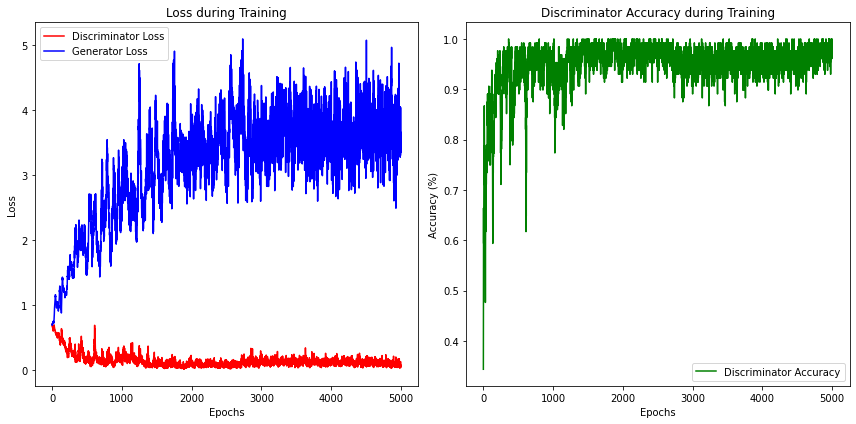

Label counts before adding synthetic data:
normal             67343
back                 956
land                  18
neptune            41214
pod                  201
smurf               2646
teardrop             892
ipsweep             3599
nmap                1493
portsweep           2931
satan               3633
ftp_write              8
guess_passwd          53
imap                  11
multihop               7
phf                    4
spy                    2
warezclient          890
warezmaster           20
buffer_overflow       30
loadmodule             9
perl                   3
rootkit               10
dtype: int64
Label counts after adding synthetic data:
normal             67343.0
back                 956.0
land                 200.0
neptune            41214.0
pod                  201.0
smurf               2646.0
teardrop             892.0
ipsweep             3599.0
nmap                1493.0
portsweep           2931.0
satan               3633.0
ftp_write            200.0
gue

In [ ]:

# ---------------------- Hyperparameter Details ---------------------- #
# 
# 1. **GAN Parameters (Generative Adversarial Network)**
#    - `batch_size`: Number of samples per batch during training.
#    - `learning_rate (0.0002)`: Controls how much the model updates per step.
#    - `latent_dim (100)`: The size of the random noise vector for generating data.
#    - `input_dim (states.shape[1])`: The number of features in the input data.
#    - `hidden_dim (128)`: Number of neurons in hidden layers of the GAN.
#    - `num_classes (len(env.attack_types))`: Number of different attack types to classify.
#
# 2. **Training Parameters**
#    - `num_episodes (50)`: Total number of training episodes.
#    - `iterations_episode (100)`: Number of steps per episode.
#    - `minibatch_size (100)`: Number of samples to use per gradient update.
#    - `ExpRep (True)`: Whether to use Experience Replay for training.
#
# 3. **Defender Agent Hyperparameters**
#    - `epsilon (1)`: Initial exploration rate for the defender.
#    - `min_epsilon (0.01)`: Minimum exploration rate.
#    - `gamma (0.001)`: Discount factor for future rewards.
#    - `decay_rate (0.99)`: Rate at which epsilon decays.
#    - `hidden_size (100)`: Number of neurons per hidden layer.
#    - `hidden_layers (5)`: Number of hidden layers in the model.
#    - `learning_rate (0.2)`: Learning rate for the defender.
#    - `mem_size (1000)`: Size of the replay memory.
#
# 4. **Attacker Agent Hyperparameters**
#    - `epsilon (1)`: Initial exploration rate for the attacker.
#    - `min_epsilon (0.82)`: Minimum exploration rate for the attacker.
#    - `gamma (0.001)`: Discount factor for future rewards.
#    - `decay_rate (0.99)`: Epsilon decay rate.
#    - `hidden_layers (3)`: Number of hidden layers in the attacker's neural network.
#    - `hidden_size (100)`: Number of neurons per hidden layer.
#    - `learning_rate (0.2)`: Learning rate for the attacker.
#    - `mem_size (1000)`: Replay memory size.
# -------------------------------------------------------------------- #

# Load your original dataset
formated_test_path = "formated_test_adv_" + ismModifDataset + ".data"
env_test = RLenv('test', formated_test_path=formated_test_path)

kdd_train = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTrain%2B.txt"
kdd_test = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTest%2B.txt"

formated_train_path = "formated_train_adv_" + ismModifDataset + ".data"
formated_test_path = "formated_test_adv_" + ismModifDataset + ".data"

# Train batch
batch_size = 1
minibatch_size = 100
ExpRep = True
iterations_episode = 100

# Initialization of the environment
env = RLenv('train', train_path=kdd_train, test_path=kdd_test,
            formated_train_path=formated_train_path,
            formated_test_path=formated_test_path, batch_size=batch_size,
            iterations_episode=iterations_episode)
obs_size = env.data_shape[1] - len(env.all_attack_names)

# Load original training data
states, labels = env.get_full()
#print('States ',states.columns,states.shape)
#print('LABELS ',labels.columns,labels.shape)

# Convert labels to numerical format
label_mapping = {name: idx for idx, name in enumerate(env.attack_names)}
numerical_labels = np.array([label_mapping[label.idxmax()] for _, label in labels.iterrows()])

print(env.attack_names)
# Initialize the GAN model with appropriate parameters
print(states.shape[1])
noise_dim = 500  # Change to match generator input
# Initialize GAN with arguments: batch_size, lr, noise_dim, data_dim, layers_dim, num_classes
gan_args = [64, 1e-4, noise_dim, states.shape[1], 128, len(env.attack_names)]
gan = GAN(gan_args,env.attack_names)

# Prepare the data for GAN
data = env.df.copy(deep=True)

# Identify the columns to remove (those that are in env.all_attack_names but not in env.attack_names)
columns_to_remove = list(set(env.all_attack_names) - set(env.attack_names))

# Drop the columns from the DataFrame
data = data.drop(columns=columns_to_remove)
# Now `data` contains only the columns from `env.attack_names`

# Train the GAN model
# Initialize training parameters: cache_prefix, epochs, sample_interval, num_classes
train_args = ['gan_model', 5000, 200, len(env.attack_names)]
print(data.shape)
gan.train(data, train_args)

# Generate synthetic samples for underrepresented classes
samples_per_class = 200
synthetic_states = []
synthetic_labels = []

# Print the number of each label before adding synthetic data
print("Label counts before adding synthetic data:")
prev_label_counts = data[env.attack_names].sum()
print(prev_label_counts)  # Print the counts of each label before adding synthetic data

# Append the counts to the log, converting the Series to a string
append_log("Label counts before adding synthetic data:\n" + str(prev_label_counts))
# Generate and add synthetic data
for class_idx, attack_name in enumerate(env.attack_names):
    class_count = np.sum(labels[attack_name] == 1)  # Count samples for the current attack
    if class_count < samples_per_class:
        samples_needed = samples_per_class - class_count

        # Create synthetic labels separately
        synthetic_labels_batch = np.zeros((samples_needed, len(env.attack_names)))  
        synthetic_labels_batch[:, class_idx] = 1  # Set only the current attack label to 1

        noise = np.random.normal(0, 1, (samples_needed, noise_dim))  # Generate noise
        synthetic_class_samples = gan.generator.predict([noise, synthetic_labels_batch])  # Generate synthetic data

        synthetic_states.append(synthetic_class_samples)
        synthetic_labels.append(synthetic_labels_batch)  # Use synthetic_labels_batch instead of labels

# Combine synthetic data
if synthetic_states:
    synthetic_states = np.vstack(synthetic_states)
    synthetic_labels = np.vstack(synthetic_labels)

    # Create DataFrame for synthetic data
    synthetic_df = pd.DataFrame(synthetic_states, columns=states.columns)
    synthetic_labels_df = pd.DataFrame(synthetic_labels, columns=env.attack_names)

    # Combine synthetic states and labels
    synthetic_df = pd.concat([synthetic_df, synthetic_labels_df], axis=1)

    # Append synthetic data to the original DataFrame
    env.df = pd.concat([env.df, synthetic_df], ignore_index=True)

    # Shuffle the updated DataFrame
    env.df = shuffle(env.df, random_state=random_seed)


# Print the number of each label after adding synthetic data
print("Label counts after adding synthetic data:")
print(env.df[env.attack_names].sum())  # Sum across the label columns to count occurrences of each attack class
append_log("Label counts after adding synthetic data:\n" + str(env.df[env.attack_names].sum()))

# Calculate and print the number of labels added
added_labels = env.df[env.attack_names].sum() - prev_label_counts
print("Number of labels added (per attack class):")
print(added_labels)
append_log("Number of labels added (per attack class):\n" + str(added_labels))

# Print the total number of samples for each label (before and after)
print("\nTotal number of samples for each label (before and after):")
append_log("\nTotal number of samples for each label (before and after):\n" + str(prev_label_counts) + "\n" + str(env.df[env.attack_names].sum()))



# Update states and labels attributes to reflect the new DataFrame
env.states = env.df.drop(columns=env.attack_names)
env.labels = env.df[env.attack_names]


num_episodes = 100

defender_valid_actions = list(range(len(env.attack_types)))
defender_num_actions = len(defender_valid_actions)

def_epsilon = 1
def_min_epsilon = 0.01
def_gamma = 0.001
def_decay_rate = 0.99

def_hidden_size = 100
def_hidden_layers = 3
def_learning_rate = 0.00025

defender_agent = DefenderAgent(defender_valid_actions, obs_size, "EpsilonGreedy",
                               epoch_length=iterations_episode,
                               epsilon=def_epsilon,
                               min_epsilon=def_min_epsilon,
                               decay_rate=def_decay_rate,
                               gamma=def_gamma,
                               hidden_size=def_hidden_size,
                               hidden_layers=def_hidden_layers,
                               minibatch_size=minibatch_size,
                               mem_size=1000,
                               learning_rate=def_learning_rate,
                               ExpRep=ExpRep)

attack_valid_actions = list(range(len(env.attack_names)))
attack_num_actions = len(attack_valid_actions)

att_epsilon = 1
att_min_epsilon = 0.82
att_gamma = 0.001
att_decay_rate = 0.99

att_hidden_layers = 1
att_hidden_size = 100
att_learning_rate = 0.00025

attacker_agent = AttackAgent(attack_valid_actions, obs_size, "EpsilonGreedy",
                             epoch_length=iterations_episode,
                             epsilon=att_epsilon,
                             min_epsilon=att_min_epsilon,
                             decay_rate=att_decay_rate,
                             gamma=att_gamma,
                             hidden_size=att_hidden_size,
                             hidden_layers=att_hidden_layers,
                             minibatch_size=minibatch_size,
                             mem_size=1000,
                             learning_rate=att_learning_rate,
                             ExpRep=ExpRep)


# ---------------------------
# Collect all parameters and statistics into a dictionary
# ---------------------------
modif_desc_dict = {
    "ismModifDataset": ismModifDataset,
    "formated_train_path": formated_train_path,
    "formated_test_path": formated_test_path,
    "kdd_train": kdd_train,
    "kdd_test": kdd_test,
    "batch_size": batch_size,
    "minibatch_size": minibatch_size,
    "ExpRep": ExpRep,
    "iterations_episode": iterations_episode,
    "obs_size": obs_size,
    "noise_dim": noise_dim,
    "gan_args": gan_args,
    "train_args": train_args,
    "samples_per_class": samples_per_class,
    "num_episodes": num_episodes,
    "defender_valid_actions": defender_valid_actions,
    "defender_num_actions": defender_num_actions,
    "def_epsilon": def_epsilon,
    "def_min_epsilon": def_min_epsilon,
    "def_gamma": def_gamma,
    "def_decay_rate": def_decay_rate,
    "def_hidden_size": def_hidden_size,
    "def_hidden_layers": def_hidden_layers,
    "def_learning_rate": def_learning_rate,
    "attack_valid_actions": attack_valid_actions,
    "attack_num_actions": attack_num_actions,
    "att_epsilon": att_epsilon,
    "att_min_epsilon": att_min_epsilon,
    "att_gamma": att_gamma,
    "att_decay_rate": att_decay_rate,
    "att_hidden_layers": att_hidden_layers,
    "att_hidden_size": att_hidden_size,
    "att_learning_rate": att_learning_rate,
    # Training summary info
    "Total_epoch": num_episodes,
    "Iterations_per_epoch": iterations_episode,
    "Total_Samples": num_episodes * iterations_episode,
    "Dataset_shape": env.get_shape(),
    "Attacker_parameters": {
        "Num_actions": attack_num_actions,
        "gamma": att_gamma,
        "epsilon": att_epsilon,
        "ANN_hidden_size": att_hidden_size,
        "ANN_hidden_layers": att_hidden_layers
    },
    "Defense_parameters": {
        "Num_actions": defender_num_actions,
        "gamma": def_gamma,
        "epsilon": def_epsilon,
        "ANN_hidden_size": def_hidden_size,
        "ANN_hidden_layers": def_hidden_layers
    }
}


append_log("\n".join([f"{key}: {value}" for key, value in modif_desc_dict.items()]))

# Statistics
att_reward_chain = []
def_reward_chain = []
att_loss_chain = []
def_loss_chain = []
def_total_reward_chain = []
att_total_reward_chain = []

stats_desc = "\n-------------------------------------------------------------------------------"
stats_desc += f"\nTotal epoch: {num_episodes} | Iterations in epoch: {iterations_episode} " \
              f"| Minibatch from mem size: {minibatch_size} | Total Samples: {num_episodes * iterations_episode}|"
stats_desc += "\n-------------------------------------------------------------------------------"
stats_desc += f"\nDataset shape: {env.get_shape()}"
stats_desc += "\n-------------------------------------------------------------------------------"
stats_desc += f"\nAttacker parameters: Num_actions={attack_num_actions} | gamma={att_gamma} | " \
              f"epsilon={att_epsilon} | ANN hidden size={att_hidden_size} | " \
              f"ANN hidden layers={att_hidden_layers}|"
stats_desc += "\n-------------------------------------------------------------------------------"
stats_desc += f"\nDefense parameters: Num_actions={defender_num_actions} | gamma={def_gamma} | " \
              f"epsilon={def_epsilon} | ANN hidden size={def_hidden_size} | " \
              f"ANN hidden layers={def_hidden_layers}|"
stats_desc += "\n-------------------------------------------------------------------------------"

print(stats_desc)
append_log(stats_desc)


# Main loop
attacks_by_epoch = []
attack_labels_list = []
for epoch in range(num_episodes):
    start_time = time.time()
    att_loss = 0.
    def_loss = 0.
    def_total_reward_by_episode = 0
    att_total_reward_by_episode = 0
    states = env.reset()
    
    attack_actions = attacker_agent.act(states)
    states = env.get_states(attack_actions)
    done = False
    
    attacks_list = []
    for i_iteration in range(iterations_episode):
        attacks_list.append(attack_actions[0])
        defender_actions = defender_agent.act(states)
        next_states, def_reward, att_reward, next_attack_actions, done = env.act(defender_actions, attack_actions)
        
        attacker_agent.learn(states, attack_actions, next_states, att_reward, done)
        defender_agent.learn(states, defender_actions, next_states, def_reward, done)
        
        if ExpRep and epoch * iterations_episode + i_iteration >= minibatch_size:
            def_loss += defender_agent.update_model()
            att_loss += attacker_agent.update_model()
        elif not ExpRep:
            def_loss += defender_agent.update_model()
            att_loss += attacker_agent.update_model()
        
        states = next_states
        attack_actions = next_attack_actions
        def_total_reward_by_episode += np.sum(def_reward, dtype=np.int32)
        att_total_reward_by_episode += np.sum(att_reward, dtype=np.int32)
    
    attacks_by_epoch.append(attacks_list)
    def_reward_chain.append(def_total_reward_by_episode)
    att_reward_chain.append(att_total_reward_by_episode)
    def_loss_chain.append(def_loss)
    att_loss_chain.append(att_loss)
    
    test_states, test_labels = env_test.get_full()
    num_samples = test_labels.shape[0]
    num_classes = len(env_test.attack_types)
    mapped_labels = np.zeros((num_samples, num_classes), dtype='float32')
    
    for i, (idx, row) in enumerate(test_labels.iterrows()):
        detailed_label = row.idxmax()
        main_category = env_test.attack_map[detailed_label]
        class_index = env_test.attack_types.index(main_category)
        mapped_labels[i, class_index] = 1.0
    
    average_test_loss = defender_agent.model_network.model.evaluate(test_states, mapped_labels, verbose=0)
    test_loss = average_test_loss * 10  #test_states.shape[0]
    print("Test Loss:", test_loss)
    test_loss_chain.append(test_loss)
    
    end_time = time.time()
    print(f"\r\n|Epoch {epoch:03d}/{num_episodes:03d}| time: {end_time - start_time:.2f}|\r\n"
          f"|Def Loss {def_loss:.4f} | Def Reward in ep {def_total_reward_by_episode:03d}|\r\n"
          f"|Att Loss {att_loss:.4f} | Att Reward in ep {att_total_reward_by_episode:03d}|")
    print(f"|Def Estimated: {env.def_estimated_labels}| Att Labels: {env.def_true_labels}")
    attack_labels_list.append(env.def_true_labels)

In [ ]:
if not os.path.exists('models_KDD_'+ismModifDoss):
    os.makedirs('models_KDD_'+ismModifDoss)


###MOD-2

# Save as a single H5 file
# Ensure the directory exists
model_dir = "models_KDD_" + ismModifDoss
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
h5_model_path = os.path.join(model_dir, "defender_agent_model_Full_"+ismModif+".h5")
defender_agent.model_network.model.save(h5_model_path)


# Save the entire model (TensorFlow format, recommended)
full_model_path = os.path.join(model_dir, "defender_agent_model")

print(f"✅ Full model saved to: {h5_model_path}")




if not os.path.exists('results_KDD_'+ismModifDoss):
    os.makedirs('results_KDD_'+ismModifDoss)    

model_dir = "models_KDD_" + ismModifDoss





# Plot training results
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(len(def_reward_chain)),def_reward_chain,label='Defense')
plt.plot(np.arange(len(att_reward_chain)),att_reward_chain,label='Attack')
plt.title('Total reward by episode')
plt.xlabel('n Episode')
plt.ylabel('Total reward')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

plt.subplot(212)
plt.plot(np.arange(len(def_loss_chain)), def_loss_chain, label='Training Loss (Defender)')
plt.plot(np.arange(len(att_loss_chain)), att_loss_chain, label='Training Loss (Attacker)')
plt.plot(np.arange(len(test_loss_chain)), test_loss_chain, label='Test Loss (Defender)', linestyle='dashed')
plt.title('Loss by episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()
#plt.show()
plt.tight_layout()
plt.savefig('results_KDD_'+ismModifDoss+'/loss_comparison_'+ismModif+'.svg', format='svg', dpi=1000)


# Ensure the number of bins matches the number of attack names
bins = np.arange(len(env_test.attack_names)) - 0.5  # Ensure correct bin count

valid_epochs = [e for e in [0, 70, 90] if e < len(attacks_by_epoch)]

plt.figure(2, figsize=[12,5])
plt.title("Attacks distribution throughout episodes")

for indx, e in enumerate(valid_epochs):
    plt.subplot(1, len(valid_epochs), indx + 1)  # Adjust for available data
    plt.hist(attacks_by_epoch[e], bins=bins, width=0.9, align='left')
    plt.xlabel(f"Epoch {e}")
    
    # Make sure the number of bins matches the number of attack names
    plt.xticks(np.arange(len(env_test.attack_names)), env_test.attack_names, rotation=90)

plt.tight_layout()

plt.savefig(f'results_KDD_{ismModifDoss}/Attacks_distribution_{ismModif}.svg', format='svg', dpi=1000)
# MOD-1 Stop

 # Plot attacks distribution alongside -MOD_1

valid_epochs = [e for e in [0,10,20,30,40,60,70,80,90] if e < len(attack_labels_list)]

plt.figure(3, figsize=[10,10])
plt.title("Attacks (mapped) distribution throughout episodes")

for indx, e in enumerate(valid_epochs):
    plt.subplot(3, 3, indx + 1)  # Adjust for available data
    plt.bar(range(5), attack_labels_list[e], tick_label=['Normal','Dos','Probe','R2L','U2R'])
    plt.xlabel(f"Epoch {e}")

plt.tight_layout()
plt.savefig(f'results_KDD_{ismModifDoss}/Attacks_mapped_distribution_{ismModif}.svg', format='svg', dpi=1000)


In [ ]:
import itertools

from sklearn.metrics import  confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


formated_test_path = "formated_test_adv_" + ismModifDataset + ".data"

env_test = RLenv('test', formated_test_path=formated_test_path)


def append_log(content):
    """Appends a string to the log file inside the model directory."""
    with open(log_file_path, "a", encoding="utf-8") as file:
        file.write(content + "\n")

# Define paths
model_dir = "models_KDD_" + ismModifDoss
h5_model_path = os.path.join(model_dir, "defender_agent_model_Full_" + ismModif + ".h5")
formated_test_path = "formated_test_adv_" + ismModifDataset + ".data"

# Load the trained model from H5 file
model = load_model(h5_model_path, compile=False)

# Compile model (optional: specify loss and optimizer if needed)
model.compile(loss=huber_loss, optimizer="sgd")

# Define environment
env_test = RLenv('test', formated_test_path=formated_test_path)

total_reward = 0    

true_labels = np.zeros(len(env_test.attack_types), dtype=int)
estimated_labels = np.zeros(len(env_test.attack_types), dtype=int)
estimated_correct_labels = np.zeros(len(env_test.attack_types), dtype=int)

# Load test data
states, labels = env_test.get_full()

start_time = time.time()
q = model.predict(states)
actions = np.argmax(q, axis=1)

maped = []
for indx, label in labels.iterrows():
    maped.append(env_test.attack_types.index(env_test.attack_map[label.idxmax()]))

labels, counts = np.unique(maped, return_counts=True)
true_labels[labels] += counts

for indx, a in enumerate(actions):
    estimated_labels[a] += 1              
    if a == maped[indx]:
        total_reward += 1
        estimated_correct_labels[a] += 1

# One-hot encoding for evaluation metrics
action_dummies = pd.get_dummies(actions)
posible_actions = np.arange(len(env_test.attack_types))
for non_existing_action in posible_actions:
    if non_existing_action not in action_dummies.columns:
        action_dummies[non_existing_action] = np.uint8(0)
labels_dummies = pd.get_dummies(maped)

# Compute F1 Scores for each attack type
f1_scores = [
    f1_score(labels_dummies[i].values, action_dummies[i].values)
    for i in range(len(env_test.attack_types))
]

# Compute Accuracy
Mismatch = estimated_labels - true_labels
acc = float(100 * total_reward / len(states))

# Print results
print('\nTotal reward: {} | Number of samples: {} | Accuracy = {:.2f}%'.format(
      total_reward, len(states), acc))
append_log('\nTotal reward: {} | Number of samples: {} | Accuracy = {:.2f}%'.format(
      total_reward, len(states), acc))
# Create DataFrame for results
outputs_df = pd.DataFrame(index=env_test.attack_types, columns=["Estimated", "Correct", "Total", "F1_score", "Mismatch"])
for indx, att in enumerate(env_test.attack_types):
   outputs_df.iloc[indx].Estimated = estimated_labels[indx]
   outputs_df.iloc[indx].Correct = estimated_correct_labels[indx]
   outputs_df.iloc[indx].Total = true_labels[indx]
   outputs_df.iloc[indx].F1_score = f1_scores[indx] * 100
   outputs_df.iloc[indx].Mismatch = abs(Mismatch[indx])

print(outputs_df)
append_log(outputs_df.to_string())
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
pos = np.arange(len(true_labels))

plt.bar(pos, estimated_correct_labels, width, color='g', label="Correct estimated")
plt.bar(pos + width, np.abs(estimated_correct_labels - true_labels), width, color='r', label="False negative")
plt.bar(pos + width, np.abs(estimated_labels - estimated_correct_labels), width, 
        bottom=np.abs(estimated_correct_labels - true_labels), color='b', label="False positive")

ax.set_xticks(pos + width / 2)
ax.set_xticklabels(env_test.attack_types, rotation='vertical', fontsize='xx-large')
ax.yaxis.set_tick_params(labelsize=15)
plt.legend(fontsize='x-large')
plt.tight_layout()
plt.savefig(f'results_KDD_{ismModifDoss}/test_adv_imp_{ismModif}.svg', format='svg', dpi=1000)

# Print evaluation metrics
aggregated_data_test = np.array(maped)
print('\nPerformance measures on Test data')
append_log('\nPerformance measures on Test data')
print(f'Accuracy = {accuracy_score(aggregated_data_test, actions):.4f}')
append_log(f'Accuracy = {accuracy_score(aggregated_data_test, actions):.4f}')
print(f'F1 = {f1_score(aggregated_data_test, actions, average="weighted"):.4f}')
append_log(f'F1 = {f1_score(aggregated_data_test, actions, average="weighted"):.4f}')
print(f'Precision = {precision_score(aggregated_data_test, actions, average="weighted"):.4f}')
append_log(f'Precision = {precision_score(aggregated_data_test, actions, average="weighted"):.4f}')
print(f'Recall = {recall_score(aggregated_data_test, actions, average="weighted"):.4f}')
append_log(f'Recall = {recall_score(aggregated_data_test, actions, average="weighted"):.4f}')

# Confusion matrix
cnf_matrix = confusion_matrix(aggregated_data_test, actions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=env_test.attack_types, normalize=True, 
                      title='Normalized confusion matrix')
plt.savefig(f'results_KDD_{ismModifDoss}/confusion_matrix_adversarial_{ismModif}.svg', format='svg', dpi=1000)

In [ ]:
print("Columns in env.df:", env.df.columns.tolist())
print(states.columns)
print(env.attack_types)
print(f"Dataset shape: {env.get_shape()}" , env.df.columns)

In [5]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define paths
model_dir = "models_KDD_" + ismModifDoss
h5_model_path = os.path.join(model_dir, "defender_agent_model_Full_" + ismModif + ".h5")
formated_test_path = "formated_test_adv_" + ismModifDataset + ".data"
formated_train_path = "formated_train_adv_" + ismModifDataset + ".data"

# Load the trained model from H5 file
model = load_model(h5_model_path, compile=False)
model.compile(loss=huber_loss, optimizer="sgd")

# Define environments
env_test = RLenv('test', formated_test_path=formated_test_path)
env_train = RLenv('train', formated_train_path=formated_train_path)

# Load test and train data
test_states, test_labels = env_test.get_full()
train_states, train_labels = env_train.get_full()

# Identify common and exclusive detailed labels
train_attack_names = set(env_train.attack_names)
test_attack_names = set(env_test.attack_names)
common_labels = train_attack_names.intersection(test_attack_names)
exclusive_labels = test_attack_names - train_attack_names

# Map to main categories for verification
train_main_categories = set([env_train.attack_map[label] for label in train_attack_names])
test_main_categories = set([env_test.attack_map[label] for label in test_attack_names])
common_main_categories = train_main_categories.intersection(test_main_categories)
exclusive_main_categories = test_main_categories - train_main_categories

print(f"Train detailed labels: {train_attack_names}")
print(f"Test detailed labels: {test_attack_names}")
print(f"Common detailed labels: {common_labels}")
print(f"Exclusive detailed labels: {exclusive_labels}")
print(f"Train main categories: {train_main_categories}")
print(f"Test main categories: {test_main_categories}")
print(f"Common main categories: {common_main_categories}")
print(f"Exclusive main categories: {exclusive_main_categories}")
append_log(f"Train detailed labels: {train_attack_names}")
append_log(f"Test detailed labels: {test_attack_names}")
append_log(f"Common detailed labels: {common_labels}")
append_log(f"Exclusive detailed labels: {exclusive_labels}")
append_log(f"Train main categories: {train_main_categories}")
append_log(f"Test main categories: {test_main_categories}")
append_log(f"Common main categories: {common_main_categories}")
append_log(f"Exclusive main categories: {exclusive_main_categories}")

# Map test labels to main categories (attack_types)
test_mapped_labels = []
test_detailed_labels = []
for _, label in test_labels.iterrows():
    detailed_label = label.idxmax()
    main_category = env_test.attack_map[detailed_label]
    test_mapped_labels.append(env_test.attack_types.index(main_category))
    test_detailed_labels.append(detailed_label)
test_mapped_labels = np.array(test_mapped_labels)
test_detailed_labels = np.array(test_detailed_labels)

# Predict actions for all test data
q = model.predict(test_states)
actions = np.argmax(q, axis=1)

# Function to evaluate a subset of data
def evaluate_subset(states, true_labels, detailed_labels, predicted_actions, label_subset, subset_name, attack_types, use_detailed=False):
    # Filter indices based on label subset
    if use_detailed:
        subset_indices = [i for i, d_label in enumerate(detailed_labels) if d_label in label_subset]
    else:
        subset_indices = [i for i, m_label in enumerate(true_labels) if env_test.attack_types[m_label] in label_subset]
    
    if not subset_indices:
        print(f"No samples found for {subset_name}")
        append_log(f"No samples found for {subset_name}")
        return None, None, None, None

    subset_states = states.iloc[subset_indices]
    subset_true_labels = true_labels[subset_indices]
    subset_predicted = predicted_actions[subset_indices]

    total_reward = np.sum(subset_true_labels == subset_predicted)
    num_samples = len(subset_true_labels)
    acc = float(100 * total_reward / num_samples) if num_samples > 0 else 0.0

    # Compute metrics
    action_dummies = pd.get_dummies(subset_predicted)
    labels_dummies = pd.get_dummies(subset_true_labels)
    all_indices = range(len(attack_types))
    action_dummies = action_dummies.reindex(columns=all_indices, fill_value=0)
    labels_dummies = labels_dummies.reindex(columns=all_indices, fill_value=0)

    f1_scores = [f1_score(labels_dummies[i].values, action_dummies[i].values) for i in all_indices]
    mismatch = np.bincount(subset_predicted, minlength=len(attack_types)) - np.bincount(subset_true_labels, minlength=len(attack_types))

    # Results DataFrame
    outputs_df = pd.DataFrame(index=attack_types, columns=["Estimated", "Correct", "Total", "F1_score", "Mismatch"])
    estimated_labels = np.bincount(subset_predicted, minlength=len(attack_types))
    true_labels_count = np.bincount(subset_true_labels, minlength=len(attack_types))
    correct_labels = np.zeros(len(attack_types), dtype=int)
    for i, (true, pred) in enumerate(zip(subset_true_labels, subset_predicted)):
        if true == pred:
            correct_labels[true] += 1

    for i, att in enumerate(attack_types):
        outputs_df.iloc[i].Estimated = estimated_labels[i]
        outputs_df.iloc[i].Correct = correct_labels[i]
        outputs_df.iloc[i].Total = true_labels_count[i]
        outputs_df.iloc[i].F1_score = f1_scores[i] * 100
        outputs_df.iloc[i].Mismatch = abs(mismatch[i])

    print(f'\n{subset_name} - Total reward: {total_reward} | Number of samples: {num_samples} | Accuracy = {acc:.2f}%')
    append_log(f'\n{subset_name} - Total reward: {total_reward} | Number of samples: {num_samples} | Accuracy = {acc:.2f}%')
    print(outputs_df)
    append_log(outputs_df.to_string())

    # Plot and save bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    pos = np.arange(len(true_labels_count))
    plt.bar(pos, correct_labels, width, color='g', label="Correct estimated")
    plt.bar(pos + width, np.abs(correct_labels - true_labels_count), width, color='r', label="False negative")
    plt.bar(pos + width, np.abs(estimated_labels - correct_labels), width, 
            bottom=np.abs(correct_labels - true_labels_count), color='b', label="False positive")
    ax.set_xticks(pos + width / 2)
    ax.set_xticklabels(attack_types, rotation='vertical', fontsize='xx-large')
    ax.yaxis.set_tick_params(labelsize=15)
    plt.legend(fontsize='x-large')
    plt.title(f"{subset_name} Performance")
    plt.tight_layout()
    bar_chart_path = f'results_KDD_{ismModifDoss}/test_bar_{subset_name.lower().replace(" ", "_")}_{ismModif}.svg'
    plt.savefig(bar_chart_path, format='svg', dpi=1000)
    plt.close()
    print(f"Bar chart saved to: {bar_chart_path}")
    append_log(f"Bar chart saved to: {bar_chart_path}")

    # Confusion matrix - Plot and save as image
    cnf_matrix = confusion_matrix(subset_true_labels, subset_predicted)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=attack_types, normalize=True, title=f'Normalized Confusion Matrix - {subset_name}')
    cm_plot_path = f'results_KDD_{ismModifDoss}/test_confusion_matrix_{subset_name.lower().replace(" ", "_")}_{ismModif}.svg'
    plt.savefig(cm_plot_path, format='svg', dpi=1000)
    plt.close()
    print(f"Confusion matrix plot saved to: {cm_plot_path}")
    append_log(f"Confusion matrix plot saved to: {cm_plot_path}")


    return acc, f1_score(subset_true_labels, subset_predicted, average="weighted"), precision_score(subset_true_labels, subset_predicted, average="weighted"), recall_score(subset_true_labels, subset_predicted, average="weighted")

# Test 1: All Labels (using main categories)
acc_all, f1_all, prec_all, rec_all = evaluate_subset(test_states, test_mapped_labels, test_detailed_labels, actions, set(env_test.attack_types), "All Labels", env_test.attack_types, use_detailed=False)

# Test 2: Common Labels (using detailed labels)
acc_common, f1_common, prec_common, rec_common = evaluate_subset(test_states, test_mapped_labels, test_detailed_labels, actions, common_labels, "Common Labels", env_test.attack_types, use_detailed=True)

# Test 3: Exclusive Labels (using detailed labels)
acc_exclusive, f1_exclusive, prec_exclusive, rec_exclusive = evaluate_subset(test_states, test_mapped_labels, test_detailed_labels, actions, exclusive_labels, "Exclusive Labels", env_test.attack_types, use_detailed=True)

# Print summary of performance metrics
print('\nPerformance measures on Test data - Summary')
append_log('\nPerformance measures on Test data - Summary')
for name, acc, f1, prec, rec in [
    ("All Labels", acc_all, f1_all, prec_all, rec_all),
    ("Common Labels", acc_common, f1_common, prec_common, rec_common),
    ("Exclusive Labels", acc_exclusive, f1_exclusive, prec_exclusive, rec_exclusive)
]:
    if acc is not None:  # Only print if there were samples to evaluate
        print(f'{name}:')
        print(f'Accuracy = {acc/100:.4f}')
        print(f'F1 = {f1:.4f}')
        print(f'Precision = {prec:.4f}')
        print(f'Recall = {rec:.4f}')
        append_log(f'{name}:')
        append_log(f'Accuracy = {acc/100:.4f}')
        append_log(f'F1 = {f1:.4f}')
        append_log(f'Precision = {prec:.4f}')
        append_log(f'Recall = {rec:.4f}')

Train detailed labels: {'satan', 'neptune', 'guess_passwd', 'rootkit', 'teardrop', 'spy', 'imap', 'warezclient', 'normal', 'back', 'pod', 'buffer_overflow', 'smurf', 'ftp_write', 'perl', 'nmap', 'phf', 'portsweep', 'ipsweep', 'loadmodule', 'multihop', 'land', 'warezmaster'}
Test detailed labels: {'snmpguess', 'httptunnel', 'satan', 'apache2', 'neptune', 'snmpgetattack', 'guess_passwd', 'named', 'rootkit', 'teardrop', 'mailbomb', 'xterm', 'xlock', 'normal', 'back', 'pod', 'sendmail', 'buffer_overflow', 'smurf', 'sqlattack', 'ftp_write', 'perl', 'nmap', 'phf', 'portsweep', 'ps', 'xsnoop', 'ipsweep', 'processtable', 'loadmodule', 'multihop', 'land', 'warezmaster', 'mscan', 'saint', 'worm', 'udpstorm'}
Common detailed labels: {'satan', 'neptune', 'guess_passwd', 'rootkit', 'teardrop', 'normal', 'back', 'pod', 'buffer_overflow', 'smurf', 'ftp_write', 'perl', 'nmap', 'phf', 'portsweep', 'ipsweep', 'loadmodule', 'multihop', 'land', 'warezmaster'}
Exclusive detailed labels: {'processtable', 's

/tmp/ipykernel_3277040/1327973827.py:12: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Confusion matrix plot saved to: results_KDD_DETERMINISTIC_Layer_original/test_confusion_matrix_exclusive_labels_50e.svg

Performance measures on Test data - Summary
All Labels:
Accuracy = 0.7763
F1 = 0.7717
Precision = 0.7794
Recall = 0.7763
Common Labels:
Accuracy = 0.8595
F1 = 0.8589
Precision = 0.8904
Recall = 0.8595
Exclusive Labels:
Accuracy = 0.3592
F1 = 0.4599
Precision = 0.6507
Recall = 0.3592


/home/aymenbj/AERL39_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
